In [2]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
%matplotlib inline

import stencil
import diffusion

In [3]:
def hnorm(r):
    """define ||r||_h = h ||r||_2"""
    n = len(r)
    h = 1.0 / (n+1)
    hrnorm = h * np.linalg.norm(r)
    return hrnorm

In [25]:
def interpolation1d(nc, nf):
    d = np.repeat([[1, 2, 1]], nc, axis=0).T
    
    I = np.zeros((3,nc))
    for i in range(nc):
        I[:,i] = [2*i, 2*i+1, 2*i+2]
    J = np.repeat([np.arange(nc)], 3, axis=0)
    P = sparse.coo_matrix(
        (d.ravel(), (I.ravel(), J.ravel()))
        ).tocsr()
    
    return 0.5 * P

def relax(A, u, f, nu):
    DE = sparse.tril(A).tocsc()
    
    for i in range(nu):
        u = u + sla.spsolve(DE, f - A * u, permc_spec='NATURAL')
    return u
    
def create_operator(n, sten):
    A = stencil.stencil_grid(sten, (n,n), format='csr')
    return A

In [12]:
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
A = create_operator(2**3-1, sten)
#print(A.toarray())
#plt.figure(figsize=(8,8))
#plt.spy(A, marker='s', markersize=6)

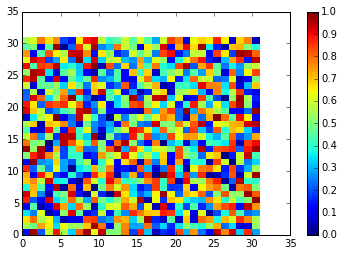

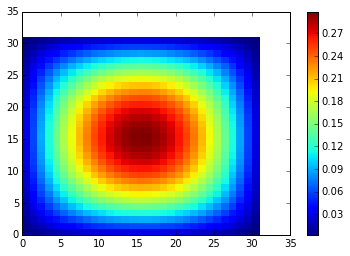

In [24]:
k = 5
n = 2**k - 1
u = np.random.rand(n*n)
f = np.zeros(n*n)
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
A = create_operator(n, sten)

plt.figure()
plt.pcolor(u.reshape(n,n))
plt.colorbar()

u = relax(A, u, f, 100)
plt.figure()
plt.pcolor(u.reshape(n,n))
plt.colorbar()

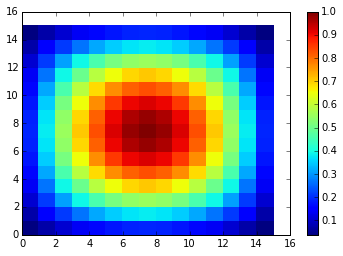

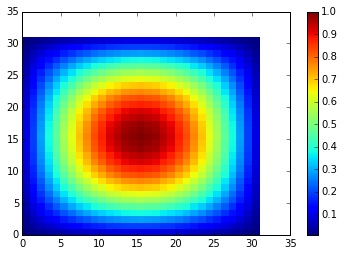

In [30]:
k = 5
nc= 2**(k-1) - 1
n = 2**k - 1
x1d = np.linspace(0,1,nc+2)[1:-1]
X, Y = np.meshgrid(x1d, x1d)
uc = np.sin(np.pi * X) * np.sin(np.pi * Y)
uc = uc.ravel()

plt.figure()
plt.pcolor(uc.reshape(nc, nc))
plt.colorbar()

P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d)
u = P * uc
plt.figure()
plt.pcolor(u.reshape(n,n))
plt.colorbar()

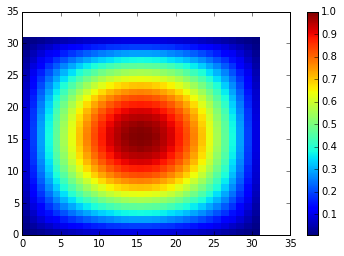

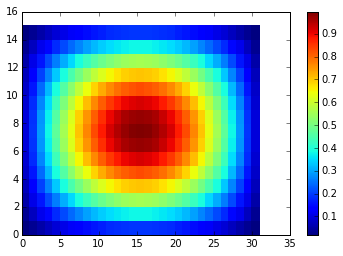

In [28]:
k = 5
nc= 2**(k-1) - 1
n = 2**k - 1
x1d = np.linspace(0,1,n+2)[1:-1]
X, Y = np.meshgrid(x1d, x1d)
u = np.sin(np.pi * X) * np.sin(np.pi * Y)

plt.figure()
plt.pcolor(u)
plt.colorbar()

P = interpolation1d(nc, n)
uc = 0.5 * P.T * u
plt.figure()
plt.pcolor(uc)
plt.colorbar()

In [32]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
A = create_operator(n, sten)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()
u = np.random.rand(n*n)
f = np.zeros((n*n,))
print(hnorm(f - A * u))

u = relax(A, u, f, 1)
fc = P.T * (f - A * u)
Ac = P.T * A * P
uc = sla.spsolve(Ac, fc)
u = u + P * uc
u = relax(A, u, f, 1)
print(hnorm(f - A * u))

u = relax(A, u, f, 1)
fc = P.T * (f - A * u)
Ac = P.T * A * P
uc = sla.spsolve(Ac, fc)
u = u + P * uc
u = relax(A, u, f, 1)
print(hnorm(f - A * u))

0.0417572645384
0.00370836089033
0.000417182131587


In [34]:
def twogrid(A, P, Ac, u, f, nu):
    u = relax(A, u, f, nu)
    fc = P.T * (f - A * u)

    uc = sla.spsolve(Ac, fc)

    u = u + P * uc
    u = relax(A, u, f, nu)
    return u

In [46]:
k = 6
n = 2**k - 1
nc = 2**(k-1) - 1
#sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
sten = diffusion.diffusion_stencil_2d(epsilon=0.00001, theta=0, type='FD')
A = (n+1)**2 * create_operator(n, sten)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()
u = np.random.rand(n*n)
f = np.zeros((n*n,))

A1 = P.T * A * P
res = [hnorm(f - A * u)]
for i in range(10):
    u = twogrid(A, P, A1, u, f, 2)
    res.append(hnorm(f - A * u))
    
res = np.array(res)
print(res[1:] / res[:-1])

[ 0.02640355  0.22482094  0.53309538  0.66174508  0.7378453   0.78758653
  0.82185859  0.8462665   0.86415066  0.87773946]


In [37]:
res

array([  3.32607113e+02,   4.14243719e+00,   9.12870130e-02,
         2.76746686e-03,   9.73878241e-05,   3.76857940e-06,
         1.57459818e-07,   6.87000872e-09,   3.11140675e-10,
         1.44354045e-11,   6.81591835e-13])

[[ -0.00000000e+00  -1.00000000e+00   0.00000000e+00]
 [ -1.00000000e-03   2.00200000e+00  -1.00000000e-03]
 [  0.00000000e+00  -1.00000000e+00  -0.00000000e+00]]


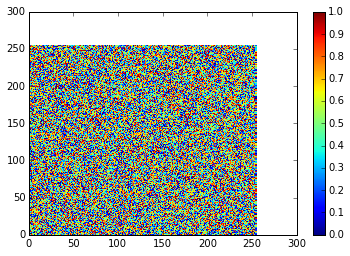

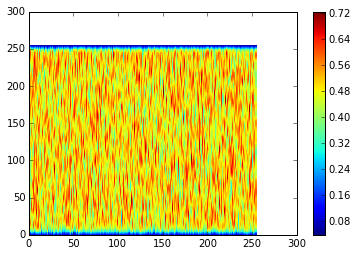

In [41]:
k = 8
n = 2**k - 1
nc = 2**(k-1) - 1
sten = diffusion.diffusion_stencil_2d(epsilon=0.001, theta=0, type='FD')
print(sten)
A = (n+1)**2 * create_operator(n, sten)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()

u = np.random.rand(n*n)
f = np.zeros((n*n,))

plt.figure()
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()

u = relax(A, u, f, 15)
plt.figure()
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()